# **Facial Expression - PCA**


Aim to find that the less amount of feature are also enough to be used in model development.

## Loading Dependencies

In [1]:
import datetime

import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
def logit(message, status):
    with open("console.log", "a") as logger:
        logger.write(f"{datetime.datetime.now()}\t[{status.upper()}]: \t{message}\n")

In [3]:
df = pd.read_csv('drive/MyDrive/Projects/Python/dataset/icml_face_data.csv')
logit("Dataset has been sucessfully loaded", "process")
logit(f"Data shape {df.shape}", "info")

In [4]:
df.shape

(35887, 3)

### Transform (ETL: 2)

In [5]:
def transform(dataset):
    dataset = dataset[["emotion", " pixels"]]
    dataset.columns = ["emotion", "pixels"]
    data = {"emotion": []}
    for i in range(2304):
        data[i] = []
    for emotion, pixels in zip(dataset.emotion, dataset.pixels):
        data["emotion"].append(int(emotion))
        for count, pixel in enumerate(pixels.split()):
            data[count].append(int(pixel))
    logit(f"Data Successfully Transformed", "process")
    return pd.DataFrame(data)

In [6]:
image_data = transform(df)
image_data.head()

,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,2264,2265,2266,2267,2268,2269,2270,2271,2272,2273,2274,2275,2276,2277,2278,2279,2280,2281,2282,2283,2284,2285,2286,2287,2288,2289,2290,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,0,70,80,82,72,58,58,60,63,54,58,60,48,89,115,121,119,115,110,98,91,84,84,90,99,110,126,143,153,158,171,169,172,169,165,129,110,113,107,95,...,20,31,40,46,65,88,108,110,125,149,157,153,162,164,158,159,154,140,78,21,11,61,144,168,173,157,138,150,148,132,159,182,183,136,106,116,95,106,109,82
1,0,151,150,147,155,148,133,111,140,170,174,182,154,153,164,173,178,185,185,189,187,186,193,194,185,183,186,180,173,166,161,147,133,172,151,114,161,161,146,131,...,150,129,143,135,115,102,111,124,112,109,132,146,135,149,148,143,163,156,159,150,139,128,116,125,133,109,130,147,130,121,105,108,95,108,102,67,171,193,183,184
2,2,231,212,156,164,174,138,161,173,182,200,106,38,39,74,138,161,164,179,190,201,210,216,220,224,222,218,216,213,217,220,220,218,217,212,174,160,162,160,139,...,225,220,215,207,199,167,108,151,122,88,71,84,120,127,105,76,71,78,90,106,123,146,155,148,130,141,119,69,54,89,104,138,152,122,114,101,97,88,110,152
3,4,24,32,36,30,32,23,19,20,30,41,21,22,32,34,21,19,43,52,13,26,40,59,65,12,20,63,99,98,98,111,75,62,41,73,118,140,192,186,187,...,124,150,161,167,169,167,162,164,169,181,172,168,169,170,174,179,180,182,196,208,226,230,140,113,114,125,135,141,172,214,174,126,132,132,133,136,139,142,143,142
4,6,4,0,0,0,0,0,0,0,0,0,0,0,3,15,23,28,48,50,58,84,115,127,137,142,151,156,155,149,153,152,157,160,162,159,145,121,83,58,48,...,18,27,19,13,11,22,37,48,55,67,88,95,112,118,123,141,157,174,181,185,184,179,176,171,155,128,105,10,0,0,12,34,31,31,31,27,31,30,29,30


### Load (ETL: 3)

In [7]:
image_data.to_csv("facial_img_data.csv", index=False)

## Visualization

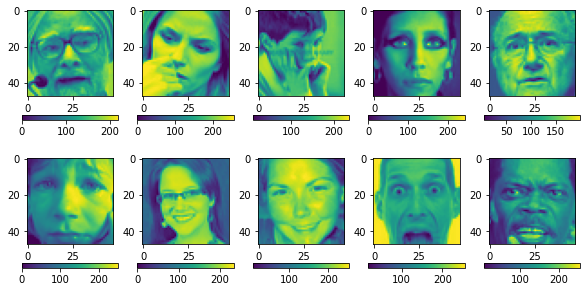

In [8]:
fig = plt.figure(figsize=(10, 5))
count = 1
for row in range(2):
    for col in range(5):
        ax = fig.add_subplot(2, 5, count)
        plt.imshow(image_data.iloc[count,1:].values.reshape(48, -1))
        plt.colorbar(orientation='horizontal')
        count += 1

### Train Test Split

In [9]:
X, y = image_data.drop("emotion", axis= 1), image_data.emotion

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("Train size:\n", "\t X: ", x_train.shape, "\n", "\t Y: ", y_train.shape)
print("Test size:\n", "\t X: ", x_test.shape, "\n", "\t Y: ", y_test.shape)

Train size:
 	 X:  (28709, 2304) 
 	 Y:  (28709,)
Test size:
 	 X:  (7178, 2304) 
 	 Y:  (7178,)


## PCA

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=269)
pca.fit(x_train)

PCA(n_components=269)

In [11]:
np.cumsum(pca.explained_variance_ratio_)[268]

0.952155974881043

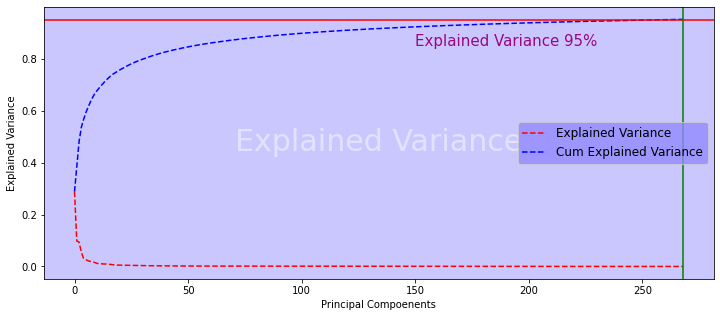

In [12]:
import seaborn as sns

plt.figure(figsize=(12,5))

for param in ['axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#928aff7a'

sns.lineplot(np.arange(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, linestyle= "--", color= 'red', markers= True, label= 'Explained Variance')
sns.lineplot(np.arange(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_), linestyle= "--", color= 'blue', markers= True, label= 'Cum Explained Variance')

# labelling graph
plt.title("Explained Variance", fontsize=30, y=0.45, color="#ffffff7a")
plt.xlabel('Principal Compoenents')
plt.ylabel('Explained Variance')
plt.legend(loc=5, frameon= True, fontsize=12)

plt.axhline(0.95, color='red') # marked 95% explained variance boundary
plt.axvline(268, color='green') # marked component explaining 95% variance
plt.text(150, 0.85, 'Explained Variance 95%', fontsize=15, color="#9a0780") # annoatations

plt.show()

## K Nearest Neighbor

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=169, n_jobs=-1)
knn.fit(x_train,y_train)
y_knn_pred = knn.predict(x_test)

In [17]:
accuracy_score(y_test, y_knn_pred)

0.3007801616049039

In [15]:
iterr = 20
mean_acc = np.zeros(iterr-1)
std_acc = np.zeros(iterr-1)

for n in range(1, iterr):
    
    knn = KNeighborsClassifier(n_neighbors=n, weights="uniform", n_jobs=-1).fit(x_train,y_train)
    
    y_pred= knn.predict(x_test)
    mean_acc[n-1] = accuracy_score(y_test, y_pred)
    
    std_acc[n-1] = np.std(y_pred==y_test)/np.sqrt(y_pred.shape[0])

print(f"Found Max accuracy {mean_acc.max()} at {mean_acc.argmax()+1} neighbor.")

Found Max accuracy 0.3959320144887155 at 1 neighbor.


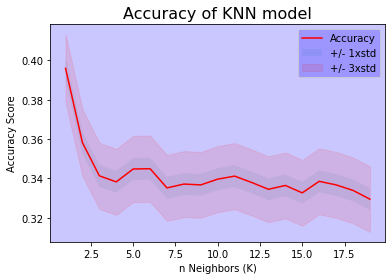

In [16]:
plt.plot(range(1,iterr), mean_acc, label='Accuracy', color='red')
plt.fill_between(range(1,iterr), mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10, label='+/- 1xstd')
plt.fill_between(range(1,iterr), mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10, label='+/- 3xstd', color="red")

plt.legend()

plt.title('Accuracy of KNN model', fontsize=16)
plt.ylabel('Accuracy Score')
plt.xlabel('n Neighbors (K)')

plt.show()

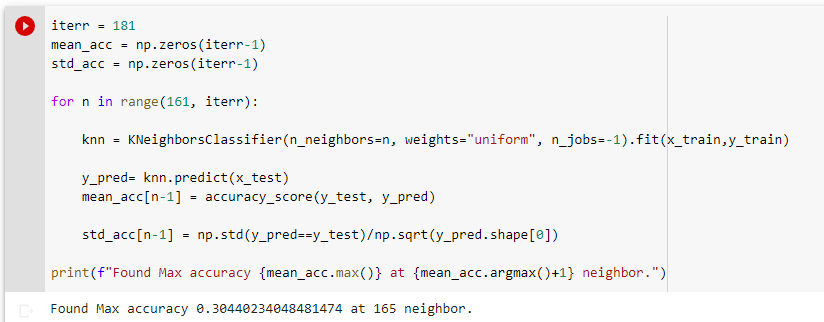